In [1]:
#%% -------- 1. Configuration Cell --------
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
import splitfolders
from timm.models import deit_base_patch16_224
from timm.loss import LabelSmoothingCrossEntropy
from torch.optim.lr_scheduler import OneCycleLR
import torchmetrics
# Hardware config
NUM_CLASSES = 6
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_WORKERS = 2
PRECISION = '16-mixed'
EPOCHS = 1
LR = 1e-5
WARMUP_EPOCHS = 3
DATA_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brain Tumour\\Brain Tumour Dataset - Radiology Team - 6 Classes"
SPLIT_ROOT = "C:\\Users\\DELL 5540\\Desktop\\Brain Tumour\\Dataset"
SEED = 42

# Reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

Seed set to 42


42

In [2]:
#%% -------- 2. Data Preparation Cell --------
def prepare_dataset():
    splitfolders.ratio(
        DATA_ROOT,
        output=SPLIT_ROOT,
        seed=SEED,
        ratio=(0.7, 0.15, 0.15),
        group_prefix=None,
        move=False
    )

if not os.path.exists(os.path.join(SPLIT_ROOT, 'train')):
    prepare_dataset()

# MRI-specific transforms
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load datasets
train_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'val'), val_transform)
test_dataset = ImageFolder(os.path.join(SPLIT_ROOT, 'test'), val_transform)

# Class balancing
class_counts = np.bincount(train_dataset.targets)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
samples_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(samples_weights, len(samples_weights), replacement=True)

Copying files: 7622 files [00:13, 583.13 files/s]


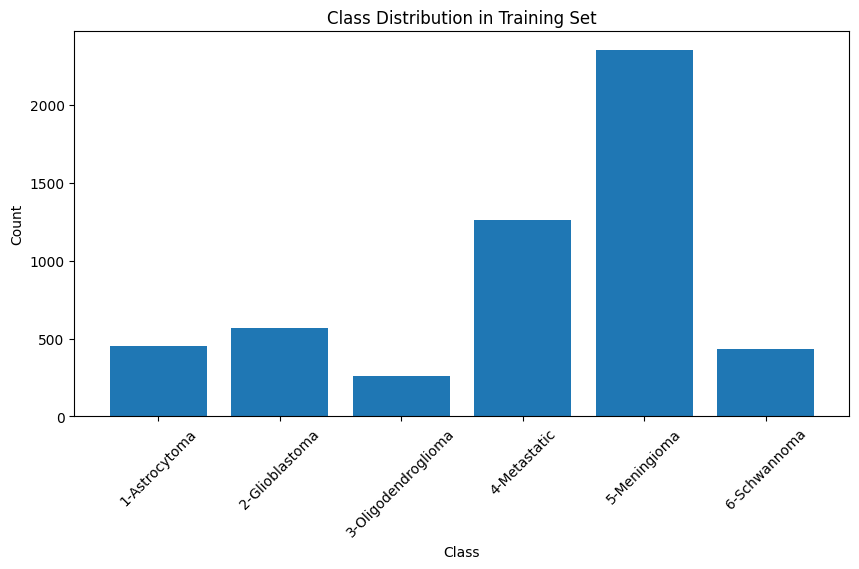

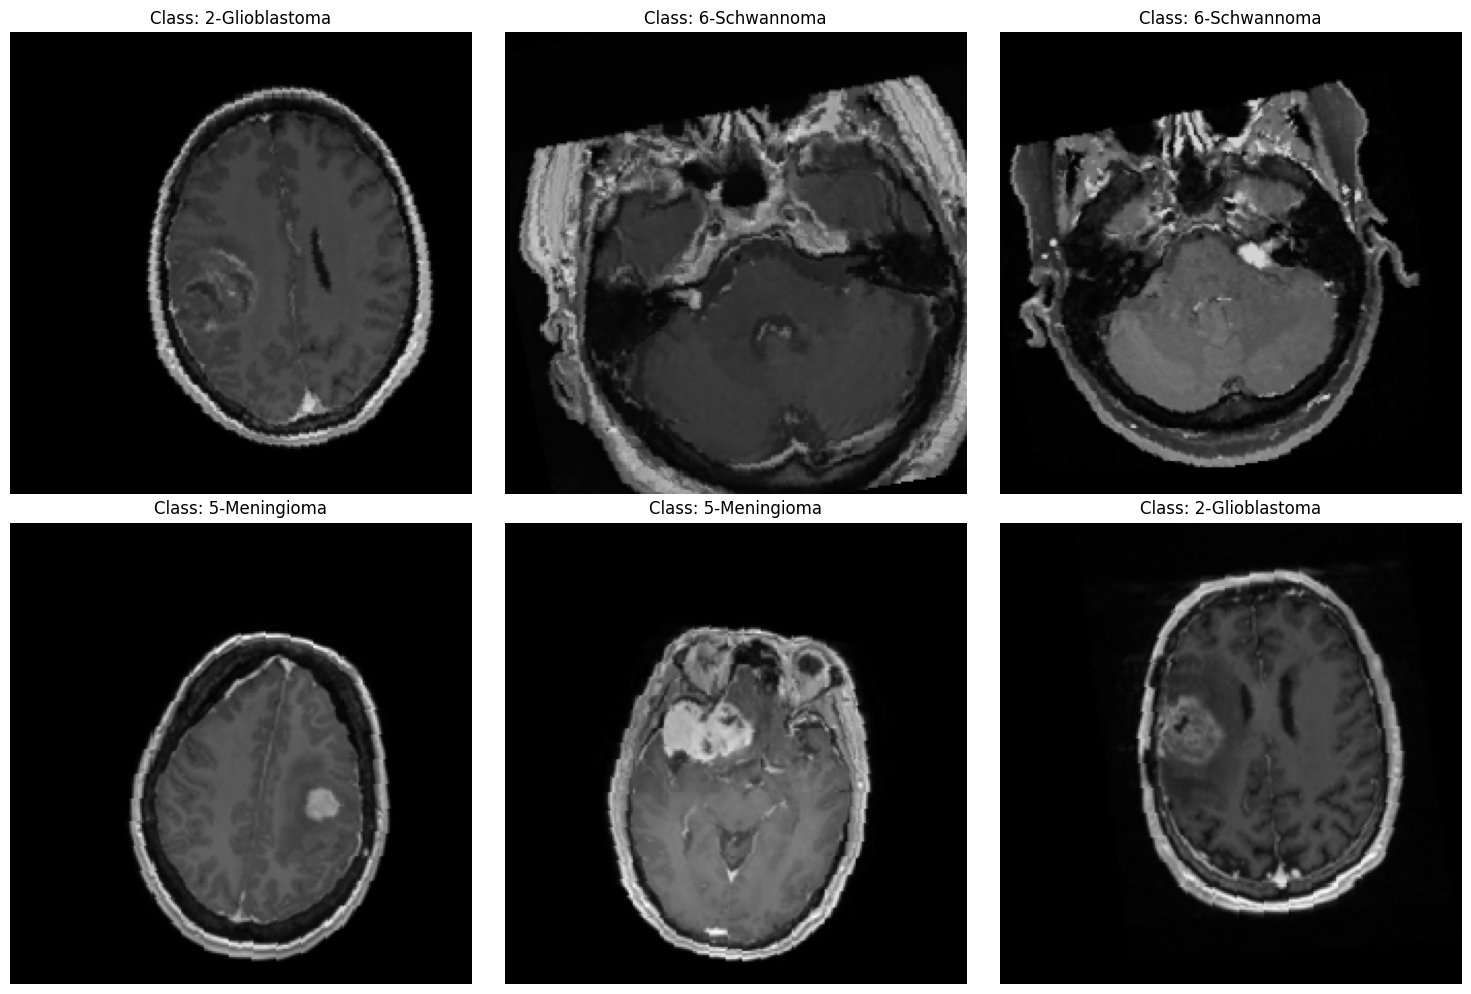

In [3]:
#%% Data Visualization Cell
import numpy as np
import matplotlib.pyplot as plt

# Extract class names from dataset
class_names = train_dataset.classes if hasattr(train_dataset, 'classes') else [str(i) for i in range(len(np.bincount(train_dataset.targets)))]

def plot_class_distribution():
    counts = np.bincount(train_dataset.targets)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(class_names)), counts, tick_label=class_names)  # Ensure proper labels
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

def show_sample_images(dataset, num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, label = dataset[idx]
        plt.subplot(2, 3, i+1)
        plt.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Unnormalize
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_class_distribution()
show_sample_images(train_dataset)


In [4]:
import torchmetrics
#%% -------- 4. Model Definition Cell --------
class BrainTumorDeiT(nn.Module):
    def __init__(self):
        super().__init__()
        self.deit = deit_base_patch16_224(pretrained=True)
        self.deit.head = nn.Sequential(
            nn.Linear(self.deit.head.in_features, 512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, NUM_CLASSES)
        )
        
        # Freezing strategy
        for param in self.deit.parameters():
            param.requires_grad = False
        for block in self.deit.blocks[-4:]:
            for param in block.parameters():
                param.requires_grad = True
        for param in self.deit.head.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.deit(x)

class LitModel(pl.LightningModule):
    def __init__(self, total_steps):
        super().__init__()
        self.model = BrainTumorDeiT()
        self.criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
        self.total_steps = total_steps
        
        # Updated metrics using torchmetrics
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.val_f1 = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.test_f1 = torchmetrics.F1Score(task='multiclass', num_classes=NUM_CLASSES)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.train_acc(logits, y)
        self.log('train_acc', self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        self.log('val_acc', self.val_acc, prog_bar=True)
        self.log('val_f1', self.val_f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.test_acc(logits, y)
        self.test_f1(logits, y)
        self.log('test_acc', self.test_acc, prog_bar=True)
        self.log('test_f1', self.test_f1, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=LR, weight_decay=0.1)
        scheduler = OneCycleLR(
            optimizer,
            max_lr=LR,
            total_steps=self.total_steps  # CHANGED: Use stored value
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",
                "frequency": 1
            }
        }


In [5]:
#%% -------- 5. Training Setup Cell --------
import torchmetrics
# First create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

# Calculate total steps after creating loaders
total_steps = EPOCHS * len(train_loader)

# Then create model with required parameter
model = LitModel(total_steps=total_steps)  # Pass the calculated steps

# Callbacks
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    filename='best-{epoch}-{val_f1:.2f}',
    save_top_k=2
)

early_stop = pl.callbacks.EarlyStopping(
    monitor='val_f1',
    patience=5,
    mode='max',
    min_delta=0.005
)

# Trainer config
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=EPOCHS,
    precision=PRECISION,
    callbacks=[checkpoint, early_stop],
    accumulate_grad_batches=4,
    gradient_clip_val=1.0,
    log_every_n_steps=10,
    deterministic=True
)

Using 16bit Automatic Mixed Precision (AMP)
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\pytorch\plugins\precision\amp.py:54: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
#%% -------- 6. Training Execution Cell --------
trainer.fit(model, train_loader, val_loader)
best_model = LitModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

Missing logger folder: c:\Users\DELL 5540\Desktop\Brain Tumour\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                       | Params
---------------------------------------------------------
0 | model     | BrainTumorDeiT             | 86.2 M
1 | criterion | LabelSmoothingCrossEntropy | 0     
2 | train_acc | MulticlassAccuracy         | 0     
3 | val_acc   | MulticlassAccuracy         | 0     
4 | val_f1    | MulticlassF1Score          | 0     
5 | test_acc  | MulticlassAccuracy         | 0     
6 | test_f1   | MulticlassF1Score          | 0     
---------------------------------------------------------
28.7 M    Trainable params
57.4 M    Non-trainable params
86.2 M    Total params
344.782   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
C:\Users\DELL 5540\AppData\Roaming\Python\Python311\site-packages\lightning\fabric\utilities\cloud_io.py:55: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

TypeError: LitModel.__init__() missing 1 required positional argument: 'total_steps'

In [ ]:
#%% Training Visualization Cell
import matplotlib.pyplot as plt
import torch

def plot_training_history(model):
    plt.figure(figsize=(15, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(torch.tensor(model.train_losses).cpu().numpy(), label='Train Loss')
    plt.plot(torch.tensor(model.val_losses).cpu().numpy(), label='Val Loss')
    plt.title('Training History - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # F1-score plot
    plt.subplot(1, 2, 2)
    plt.plot(torch.tensor(model.train_f1s).cpu().numpy(), label='Train F1')
    plt.plot(torch.tensor(model.val_f1s).cpu().numpy(), label='Val F1')
    plt.title('Training History - F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(model)

In [ ]:
#%% -------- 7. Evaluation Cell --------
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

def evaluate():
    all_preds = []
    all_targets = []
    
    best_model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(best_model.device), y.to(best_model.device)
            preds = best_model(x).argmax(1)
            all_preds.extend(preds.cpu())
            all_targets.extend(y.cpu())
    
    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Classification Report
    print(classification_report(all_targets, all_preds, target_names=train_dataset.classes))

evaluate()


In [ ]:
#%% Inference & Visualization Cell
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def predict_and_visualize(model, dataset, class_names, num_images=9):
    model.eval()
    plt.figure(figsize=(15, 15))
    
    for i in range(num_images):
        idx = np.random.randint(len(dataset))
        img, true_label = dataset[idx]
        img_tensor = img.unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        with torch.no_grad():
            logits = model(img_tensor)
            probs = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(probs).item()
        
        img_np = img.permute(1, 2, 0).cpu().numpy() * 0.229 + 0.485  # Reverse normalization
        img_np = np.clip(img_np, 0, 1)
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img_np)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}\nConf: {probs.max().item():.2f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

predict_and_visualize(best_model, test_dataset, test_dataset.classes)